# DATA IMPORT

In [134]:
import pandas as pd
import numpy as np

df_credit = pd.read_csv('credits.csv')
df_rating = pd.read_csv('ratings.csv')
df_movie = pd.read_csv('movies_metadata.csv')
df_keywords = pd.read_csv('keywords.csv')


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

In [135]:
df_movie = df_movie[['id', 'original_title', 'title', 'belongs_to_collection', 
                     'budget', 'genres', 'original_language', 'popularity',
                     'production_companies', 'production_countries', 'revenue', 
                     'runtime', 'spoken_languages', 'status', 'vote_average',
                     'vote_count']]

Preprocess rating dataframe

In [ ]:
df_rating = df_rating[['movieId', 'rating']]
df_rating_grouped = df_rating.groupby('movieId').aggregate('mean')
df_rating_grouped['id'] = df_rating_grouped.index
df_rating_grouped['id'] = df_rating_grouped['id'].apply(lambda x: str(x)).astype('object')
df_movie = df_movie.merge(df_rating_grouped, on='id', how='left')
# df_movie.id

data cleanup

In [136]:
import ast

def convertType(x, typ):
    try:
        return typ(x)
    except ValueError:
        return np.NaN

df_movie['genres_parsed'] = df_movie['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])
# df_movie['production_countries'] = df_movie['production_countries'].apply(lambda x: d['iso_3166_1'] for d in ast.literal_eval(x))

# convert boolean belongs_to_collection col to integer col with 1 and 0 value
df_movie['is_collection'] = df_movie['belongs_to_collection'].isnull()
df_movie['is_collection'] = df_movie['is_collection'].apply(lambda x: 0 if x==True else 1)

# convert boolean adult col to integer col with 1 and 0 value
# print(df_movie['adult'])
# df_movie['adult'] = df_movie['adult'].apply(lambda x: 1 if x==True else 0)
df_movie['popularity'] = df_movie['popularity'].apply(lambda x: convertType(x, float))

df_movie['budget'] = df_movie['budget'].apply(lambda x: convertType(x, int))
df_movie = df_movie[df_movie['revenue'] > 0]


# DATA ADVERTISING AND BASIC ANALYSIS

features with strong linear correlation with revenue

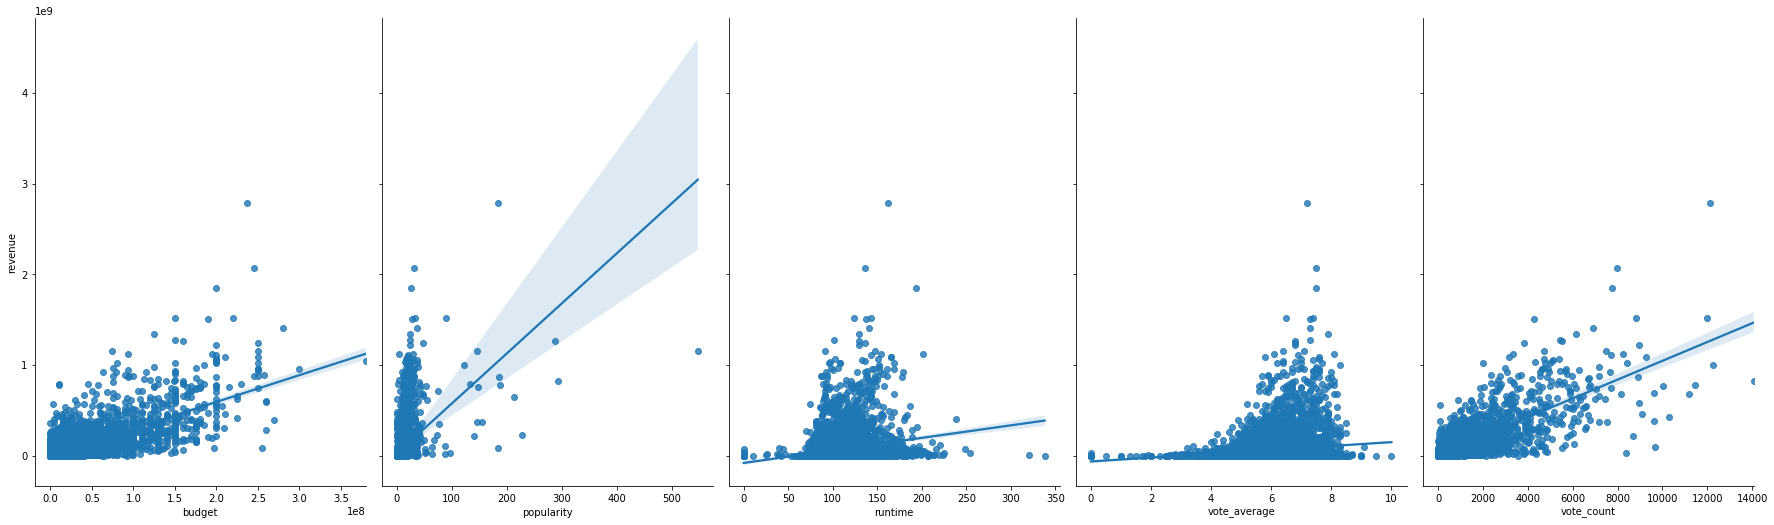

In [67]:
import seaborn as sns
x = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
# plot relationship to revenue and plotting the Least Squares Line
sns.pairplot(df_movie, x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

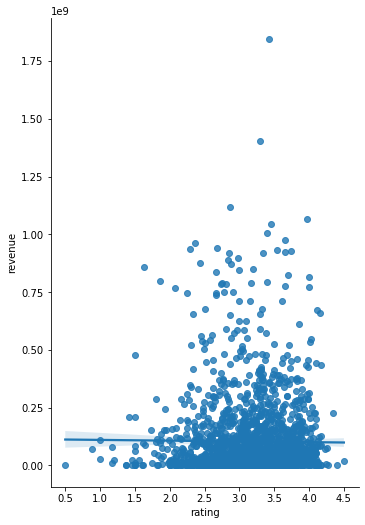

In [70]:
# popularity has extremely big r^2 value
sns.pairplot(df_movie, x_vars=['rating'], y_vars='revenue', kind='reg', height=7, aspect=0.7)



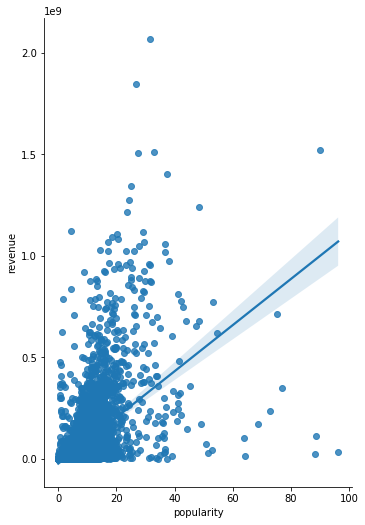

In [71]:
# popularity has extremely big r^2 value
sns.pairplot(df_movie[df_movie['popularity'] < 100], x_vars=['popularity'], y_vars='revenue', kind='reg', height=7, aspect=0.7)

In [ ]:
budget has stronger linear correlation with low budget films 

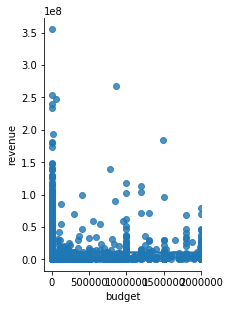

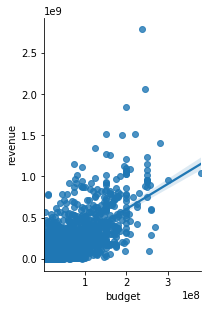

In [88]:
# too much variability in low budget films. Only going to target mainstream films for predictability.
cutoff = 4224578
cutoff = 2000000
sns.pairplot(df_movie[df_movie['budget'] <= cutoff], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['budget'] > cutoff], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)



experimental films with long runtime also filtered out for strong correlation

44864
339


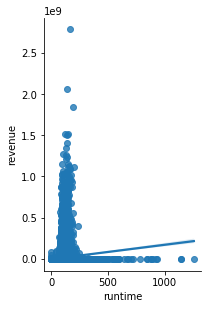

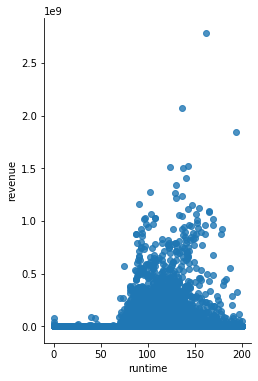

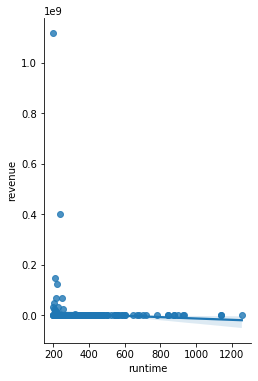

In [65]:
# too short or too long of films have really low revenue. Gaussian and therefore can't use linear regression 
# may need to cut off the films that are too long
sns.pairplot(df_movie, x_vars=['runtime'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['runtime'] <= 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
print(len(df_movie[df_movie['runtime'] <= 200]))
sns.pairplot(df_movie[df_movie['runtime'] > 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
print(len(df_movie[df_movie['runtime'] > 200]))

# FEATURE EXTRACTION

Based on the feature analysis above, we have decided on a feature set to use and filtered out outliers.(indie movies/experimental movies)

possible overlapped features removed. (popularity vs vote count)

In [374]:
df_movie_cleaned = df_movie
movie_cols = ['id', 'title', 'revenue', 'is_collection', 'popularity',
              'vote_average', 'vote_count', 'runtime', 'budget', 'genres', 'original_language']

# movie_cols = ['id', 'title', 'revenue', 'is_collection', 'adult', 'popularity', 
#               'vote_average', 'vote_count', 'runtime', 'budget']
cutoff = 2000000

filter_outlier = np.logical_and(df_movie_cleaned['revenue'] > 0, 
                                np.logical_and(df_movie_cleaned['runtime'] < 200, 
                                               df_movie_cleaned['budget'] > cutoff))

df_movie_cleaned = df_movie_cleaned[movie_cols]

# one hot encoding on categorical features
# original language
# DROP_FIRST needed because if the first category is implied if all other cols are 0.
# df_movie_cleaned = df_movie_cleaned.join(pd.get_dummies(df_movie_cleaned[['original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang'))
# 1 if english else 0
df_movie_cleaned['original_language'] = df_movie_cleaned['original_language'].apply(lambda x: 1 if x == 'en' else 0)

df_movie_cleaned = df_movie_cleaned[filter_outlier].reset_index(drop=True)
df_movie_cleaned = df_movie_cleaned.reset_index(drop=True)


df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: x if ast.literal_eval(x) else "[{\'name\': \'unknown\'}]")
df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: [d['name'].replace(' ', '_').lower()+'_genre' \
                                                                         for d in ast.literal_eval(x) if ast.literal_eval(x)])

df_movie_cleaned = df_movie_cleaned.drop('genres', 1).join(
        pd.get_dummies(
            pd.DataFrame(df_movie_cleaned.genres.tolist()).stack()
        ).astype(int).sum(level=0)
    )

print(df_movie_cleaned[df_movie_cleaned.isnull().any(axis=1)])

# Drop rows with any NAN
# df_movie_cleaned = df_movie_cleaned.dropna()

df_movie_cleaned.astype({
    'is_collection': 'int32',
    'popularity': 'float',
    'revenue': 'float',
    'vote_average': 'float',
    'vote_count': 'float',
    'runtime': 'float',
    'budget':  'int32'
})


# df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['revenue'] != 0]

df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['tv_movie_genre'] == 0]
df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['documentary_genre'] == 0]
df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['foreign_genre'] == 0]
# df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['unknown_genre'] == 0]

print('Dataset length:{}'.format(len(df_movie_cleaned)))
print(df_movie_cleaned.columns)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Empty DataFrame
Columns: [id, title, revenue, is_collection, popularity, vote_average, vote_count, runtime, budget, original_language, action_genre, adventure_genre, animation_genre, comedy_genre, crime_genre, documentary_genre, drama_genre, family_genre, fantasy_genre, foreign_genre, history_genre, horror_genre, music_genre, mystery_genre, romance_genre, science_fiction_genre, thriller_genre, tv_movie_genre, unknown_genre, war_genre, western_genre]
Index: []

[0 rows x 31 columns]
Dataset length:4610
Index(['id', 'title', 'revenue', 'is_collection', 'popularity', 'vote_average',
       'vote_count', 'runtime', 'budget', 'original_language', 'action_genre',
       'adventure_genre', 'animation_genre', 'comedy_genre', 'crime_genre',
       'documentary_genre', 'drama_genre', 'family_genre', 'fantasy_genre',
       'foreign_genre', 'history_genre', 'horror_genre', 'music_genre',
       'mystery_genre', 'romance_genre', 'science_fiction_genre',
       'thriller_genre', 'tv_movie_genre', '

# LINEAR REGRESSION MODEL

# MODEL WITH GENRES

In [378]:
drop_columns = ['id', 'title', 'vote_count']
drop_columns += ['unknown_genre', 'tv_movie_genre','documentary_genre', 'foreign_genre']
# drop_columns += ['original_language']
# df_movie_cleaned['norm'] = df_movie_cleaned['vote_count'] * df_movie_cleaned['vote_average']

df_2 =  df_movie_cleaned.drop(drop_columns, axis=1)

x = df_2.iloc[:, 1:].values
y = df_2.iloc[:, 0].values

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

regressor = LinearRegression(fit_intercept=True, n_jobs=5)
regressor.fit(x_train, y_train)

# Make Prediction
df_result = pd.DataFrame()
y_predicted = regressor.predict(x_test)
combined = np.concatenate((np.vstack((y_test)), x_test), axis=1)
df_result = pd.DataFrame(data=combined, columns=df_2.columns)
# y_predicted = y_predicted.clip(min=0) # revenue can't be less than 0

print('r^2: {}'.format(regressor.score(x_test, y_test)))
from sklearn import metrics
print('MAE', metrics.mean_absolute_error(y_test, y_predicted))
print('MSE', metrics.mean_squared_error(y_test, y_predicted))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))
# df_result['difference'] = np.absolute(df_result['predicted_revenue']-df_result['revenue'])/df_result['revenue']
# sklearn.metrics.precision_score(y_test, y_predicted)
import math
print('interecept: {}'.format(regressor.intercept_))
print('COEFFICIENTS')
d_coefficient = {col:regressor.coef_[i] for i,col in enumerate(df_2.iloc[:, 1:].columns)}
l_coef = sorted(list(zip(df_2.iloc[:, 1:].columns, regressor.coef_)),
                key=lambda x: x[1], reverse=True)
# print(sorted(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)), key=lambda x: abs(x[1]), reverse=True))
for coef in l_coef:
    print('{}: {}'.format(coef[0], coef[1]))
    

r^2: 0.6446410471533891
MAE 62265763.600585185
MSE 1.1159084810272986e+16
RMSE 105636569.47417872
interecept: -288109008.21158856
COEFFICIENTS
is_collection: 81802521.14209145
vote_average: 35655030.89449794
animation_genre: 17647119.058379855
romance_genre: 14467518.996811658
adventure_genre: 11136053.564355586
family_genre: 5680027.799736578
horror_genre: 5313532.779133887
original_language: 5046049.375160069
comedy_genre: 4347839.23385418
popularity: 2439797.827671285
runtime: 326165.4500371181
budget: 2.4894115327141515
fantasy_genre: -1730135.9269369836
music_genre: -3409691.8465586207
action_genre: -4467545.0869495245
mystery_genre: -7165572.215783746
science_fiction_genre: -8270578.1974074235
crime_genre: -8880827.194154996
thriller_genre: -8905321.088524917
drama_genre: -14956180.27908199
war_genre: -16128463.546734
history_genre: -26047388.66470094
western_genre: -35996482.952724785


In [379]:
from statsmodels.api import OLS
x_ols = df_2.iloc[:, 1:]
y_ols = df_2.iloc[:, 0]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

ols_model = OLS(y_ols,x_ols).fit()
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                revenue   R-squared (uncentered):                   0.718
Model:                            OLS   Adj. R-squared (uncentered):              0.716
Method:                 Least Squares   F-statistic:                              507.3
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                        0.00
Time:                        19:52:26   Log-Likelihood:                         -91814.
No. Observations:                4610   AIC:                                  1.837e+05
Df Residuals:                    4587   BIC:                                  1.838e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
is_collection          7.564e+07   4.09e+06     18.485      0.000    6.76e+07    8.37e+07
popularity             2.546e+06   1.15e+05     22.043      0.000    2.32e+06    2.77e+06
vote_average           1.219e+07    1.7e+06      7.158      0.000    8.85e+06    1.55e+07
runtime               -4.165e+05   9.04e+04     -4.606      0.000   -5.94e+05   -2.39e+05
budget                    2.6715      0.048     55.375      0.000       2.577       2.766
original_language     -3.927e+07   5.33e+06     -7.362      0.000   -4.97e+07   -2.88e+07
action_genre          -2.203e+07    4.3e+06     -5.127      0.000   -3.05e+07   -1.36e+07
adventure_genre        9.674e+06   4.82e+06      2.007      0.045    2.25e+05    1.91e+07
animation_genre       -8.677e+06   8.71e+06     -0.996      0.319   -2.58e+07    8.41e+06
comedy_genre          -1.895e+07    3.9e+06     -4.855      0.000   -2.66e+07   -1.13e+07
crime_genre           -1.072e+07   4.83e+06     -2.218      0.027   -2.02e+07   -1.24e+06
drama_genre            -1.45e+07    4.1e+06     -3.541      0.000   -2.25e+07   -6.47e+06
family_genre          -1.463e+05   6.76e+06     -0.022      0.983   -1.34e+07    1.31e+07
fantasy_genre         -6.248e+06   5.68e+06     -1.099      0.272   -1.74e+07     4.9e+06
history_genre         -1.728e+07   8.56e+06     -2.019      0.044   -3.41e+07   -5.01e+05
horror_genre          -2.073e+07   6.01e+06     -3.446      0.001   -3.25e+07   -8.94e+06
music_genre            1.688e+06      9e+06      0.188      0.851    -1.6e+07    1.93e+07
mystery_genre         -8.969e+06   6.09e+06     -1.474      0.141   -2.09e+07    2.96e+06
romance_genre          1.351e+07   4.52e+06      2.987      0.003    4.64e+06    2.24e+07
science_fiction_genre -1.761e+07   5.27e+06     -3.343      0.001   -2.79e+07   -7.28e+06
thriller_genre        -1.511e+07   4.31e+06     -3.507      0.000   -2.36e+07   -6.67e+06
war_genre             -1.751e+07   8.95e+06     -1.957      0.050    -3.5e+07    2.81e+04
western_genre         -2.885e+07   1.29e+07     -2.241      0.025   -5.41e+07   -3.62e+06
==============================================================================
Omnibus:                     3560.214   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           190776.495
Skew:                           3.209   Prob(JB):                         0.00
Kurtosis:                      33.855   Cond. No.                     4.44e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+08. This might indicate th

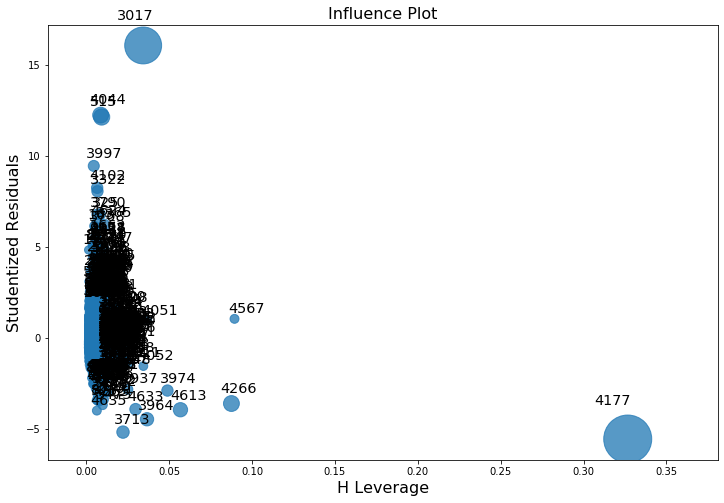

In [380]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols_model, ax=ax, criterion="cooks")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

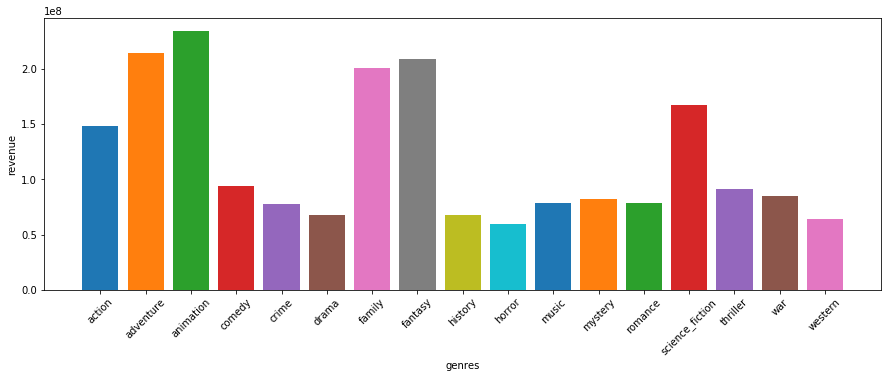

In [368]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 5))

l = list()
df_plot = df_2
for c in list(df_plot.columns):
    if '_genre' in c:
        l += [c]
        plt.bar(c[:-1*len('_genre')], df_plot[df_plot[c]==1].revenue.mean())
        
plt.xlabel('genres')
plt.ylabel('revenue')# plt.subplot(131)
plt.xticks(rotation=45)
# plt.bar(names, values)
# plt.subplot(132)
# plt.scatter(names, values)

In [ ]:
import ast
df_credit['crew'].iloc[0]
# df_credit['director'] = df_credit['director'].apply(lambda x: x if ast.literal_eval(x) else "[{\'name\': \'unknown\'}]")
# df_credit['director'] = df_credit['crew'].apply(lambda x: [d['name'].replace(' ', '_').lower()+'_director' \
#                                                                          if d['job'] == 'Director' for d in ast.literal_eval(x) if ast.literal_eval(x)])
df_credit
# df_merged = df_movie_cleaned.merge(df_credit, how='left', on='id')
# df_merged['cast_list'] = df_merged['cast'].\
#     apply(lambda x: [cast['name'].strip().replace(' ','_')+'_actor' for cast in ast.literal_eval(x)[:3]])
# df_merged = df_merged.drop('cast_list', 1).join(
#     pd.get_dummies(
#         pd.DataFrame(df_merged.cast_list.tolist()).stack()
#     ).astype(int).sum(level=0)
# ).fillna(0).reset_index(drop=True)

# MODEL WITH ACTORS

In [320]:
# categorical_feature_mask = df_movie.dtypes==object
# categorical_feature_mask
df_3 = df_movie_cleaned
df_credit.id.astype('object')
df_3.id.astype('object')
df_credit.id = df_credit.id.apply(lambda x: str(x))

import ast
df_merged = df_3.merge(df_credit, how='left', on='id')
df_merged['cast_list'] = df_merged['cast'].\
    apply(lambda x: [cast['name'].strip().replace(' ','_')+'_actor' for cast in ast.literal_eval(x)[:3]])
df_merged = df_merged.drop('cast_list', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_merged.cast_list.tolist()).stack()
    ).astype(int).sum(level=0)
).fillna(0).reset_index(drop=True)
# df_merged_finished[df_merged_finished.isnull().any(axis=1)]

drop_columns = ['id', 'title', 'unknown_genre', 'vote_count']
drop_columns += ['tv_movie_genre','documentary_genre', 'foreign_genre', 'crew', 'cast']

df_merged =  df_merged.drop(drop_columns, axis=1)

x = df_merged.iloc[:, 1:].values
y = df_merged.iloc[:, 0].values
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
regressor.score(x_test, y_test)

-148241433.23231986

In [336]:
import math
print('interecept: {}'.format(regressor.intercept_))
print('COEFFICIENTS')
d_coefficient = {col:regressor.coef_[i] for i,col in enumerate(df_merged.iloc[:, 1:].columns)}
# print(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)))
l_coef = sorted(list(zip(df_merged.iloc[:, 1:].columns, regressor.coef_)),
                key=lambda x: x[1], reverse=True)
# print(sorted(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)), key=lambda x: abs(x[1]), reverse=True))
for coef in l_coef:
    print('{}: {}'.format(coef[0], coef[1]))

interecept: -149609903.83559072
COEFFICIENTS
Frances_Fisher_actor: 1122037170.520373
Stuart_Townsend_actor: 901643449.0953516
Irrfan_Khan_actor: 689948876.0986624
Eric_Stonestreet_actor: 683510410.6157565
Neel_Sethi_actor: 666083781.422416
Manish_Dayal_actor: 648626094.2983674
Maia_Morgenstern_actor: 575593592.0134052
Ken_Jeong_actor: 568938418.1352276
Dagmara_Domińczyk_actor: 565072862.6205157
Kelsey_Grammer_actor: 518192159.23166454
Ludivine_Sagnier_actor: 510405115.0578547
Trey_Parker_actor: 505818143.57145715
Lainie_Kazan_actor: 504007392.03442615
Robert_MacNaughton_actor: 460960464.6127729
Hannah_Ware_actor: 460006056.4082962
Jillian_Bell_actor: 419669621.350813
Mammootty_actor: 411885224.1907135
Paula_Garcés_actor: 397395460.33465254
Sam_Huntington_actor: 392196337.76079077
Katrina_Kaif_actor: 390320967.5559244
Anya_Taylor-Joy_actor: 376444438.65784407
Shakira_actor: 375386260.1428893
Linda_Bassett_actor: 371004299.20488155
Sunil_Shetty_actor: 370442552.4191506
Daeg_Faerch_actor:

Dennis_Quaid_actor: 755901.7676992961
Stephen_Macht_actor: 739730.5349995235
Anna_Bonaiuto_actor: 721250.4144717675
Drake_Bell_actor: 649635.9458850535
Andree_Moss_actor: 649632.6801708791
Andrew_Caldwell_actor: 649616.4327714521
John_Kerr_actor: 646841.6144040758
Mitzi_Gaynor_actor: 646841.5629550451
Jill_Clayburgh_actor: 611708.1824300094
Robert_Hoffman_actor: 603025.2469383411
Will_Kemp_actor: 603025.2469383411
Robert_Daniel_Sloan_actor: 601392.0274217395
Ben_Affleck_actor: 590457.9125303507
Charles_Coburn_actor: 582343.9468714026
Geraldine_Fitzgerald_actor: 582306.3396446639
Alexander_Knox_actor: 582295.373837862
Joseph_Cotten_actor: 513233.1632536356
Michael_Legge_actor: 508709.31266401114
Allen_Leech_actor: 508704.11833652214
Amy_Shiels_actor: 508695.493026768
Adam_Pascal_actor: 484714.3654967893
Anthony_Rapp_actor: 484711.70909726917
Konstantin_Khabenskiy_actor: 479012.4932637805
Harry_Carey,_Jr._actor: 274960.1550894885
Pedro_Armendáriz_actor: 274959.48499015556
Julie_Entwisle_

Sam_Riley_actor: -20228579.3767546
Birol_Ünel_actor: -20267560.76933998
Adam_Bousdoukos_actor: -20267614.295617696
Daniel_Craig_actor: -20368496.386603467
Golshifteh_Farahani_actor: -20387483.009056143
Nellie_actor: -20387483.611768655
Ben_Stiller_actor: -20400594.502893638
Robin_Tunney_actor: -20455459.58425976
Bryan_Cranston_actor: -20477269.37935946
Angela_Lansbury_actor: -20545548.26741072
Charles_Cioffi_actor: -20546239.17571333
Zuleikha_Robinson_actor: -20563092.033911344
Stephen_Rea_actor: -20619250.026584137
Shaad_Randhawa_actor: -20623918.29759194
Shraddha_Kapoor_actor: -20623918.68553805
Aditya_Roy_Kapoor_actor: -20623955.90348157
Karisma_Kapoor_actor: -20649324.227898903
Jonny_Weston_actor: -20669857.870750964
Sofia_Black-D'Elia_actor: -20669858.810186416
Virginia_Gardner_actor: -20669858.810186416
Kyla_Pratt_actor: -20693105.27684973
Chris_Warren,_Jr._actor: -20693105.623956434
Kate_Reid_actor: -20714922.17449092
Walter_Pidgeon_actor: -20728136.74697627
José_Luis_García_Pér

In [321]:
# R^2 value of the model
print(regressor.score(x_test, y_test))
# calculate MAE, MSE, 
# from sklearn import metrics
# print(y_predicted.mean())
# print(metrics.mean_absolute_error(y_test, y_predicted))
# print(metrics.mean_squared_error(y_test, y_predicted))
# print(np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

-148241433.23231986


## USING OLS INSTEAD OF SCIKIT LEARN

In [279]:
from statsmodels.api import OLS
x_ols = df_2.iloc[:, 1:]
y_ols = df_2.iloc[:, 0]
ols_model = OLS(y_ols,x_ols).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     3716.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:54:26   Log-Likelihood:            -1.0249e+05
No. Observations:                5195   AIC:                         2.050e+05
Df Residuals:                    5190   BIC:                         2.050e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
popularity    9.463e+05   1.01e+05      9.377      0.000    7.48e+05    1.14e+06
vote_average -2.328e+06   1.05e+06     -2.214      0.027   -4.39e+06   -2.66e+05
vote_count    6.502e+04   1332.721     48.786      0.000    6.24e+04    6.76e+04
runtime      -5.741e+04   6.05e+04     -0.949      0.343   -1.76e+05    6.11e+04
budget           1.7392      0.039     44.737      0.000       1.663       1.815
==============================================================================
Omnibus:                     3661.218   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229131.241
Skew:                           2.725   Prob(JB):                         0.00
Kurtosis:                      35.076   Cond. No.                     4.38e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KeyboardInterrupt: 

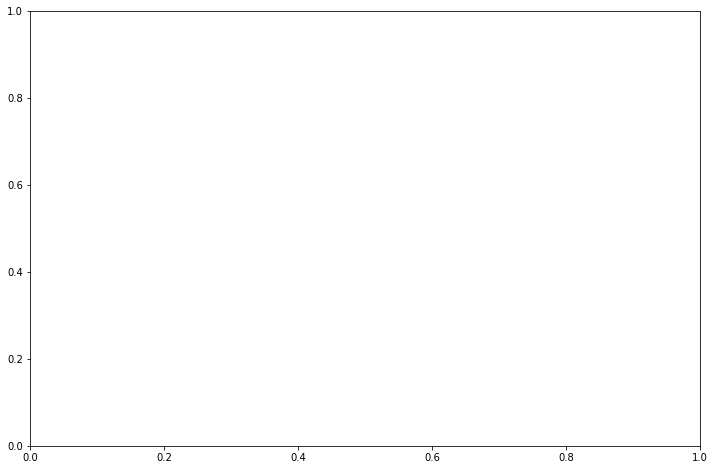

In [328]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols_model, ax=ax, criterion="cooks")

In [14]:
import re

df_credit
import ast
keywords = ast.literal_eval(df_keywords.iloc[0]['keywords'])
keywords
# re.split("},", df_credit.iloc[0]['cast'].strip(']['))
# df_credit.iloc[0]['cast'].strip('][')
# pd.to_numeric(df_movie['popularity'])
# df_movie.iloc[35587]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [ ]:
df_2 =  df_movie_cleaned.drop(['id', 'title', 'unknown'], axis=1)
x = df_2.iloc[:, 1:].values
y = df_2.iloc[:, 0].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Make Prediction
df_result = pd.DataFrame()
y_predicted = regressor.predict(x_test)
combined = np.concatenate((np.vstack((y_test)), x_test), axis=1)
df_result = pd.DataFrame(data=combined, columns=df_2.columns)
y_predicted = y_predicted.clip(min=0) # revenue can't be less than 0
regressor.score(x_test, y_test)
# df_result['difference'] = np.absolute(df_result['predicted_revenue']-df_result['revenue'])/df_result['revenue']


In [325]:
df_movie.sort_values('revenue')['belongs_to_collection'].isnull()

22731     True
29873     True
29874     True
29875     True
29876     True
29877     True
29878     True
29879     True
29880     True
29881     True
29882     True
29883     True
29884     True
29885     True
29886     True
29887     True
29890     True
29891     True
29872     True
29892     True
29871     True
29869     True
29850     True
29851     True
29852     True
29853     True
29854     True
29855     True
29856     True
29857     True
         ...  
38176    False
17124    False
41489    False
11008    False
15348    False
18252    False
23617    False
19261    False
7000     False
17293    False
26567    False
30700    False
20830    False
43255    False
42222     True
22110    False
17437    False
26558    False
28830    False
25084    False
17818    False
1639      True
26555    False
14551    False
19729     True
19730    False
29502    False
29503    False
35586     True
35587    False
Name: belongs_to_collection, Length: 45466, dtype: bool

In [323]:
np.isin( df_movie['title'], '')

array(False)

In [340]:
df_movie['original_language']

0        en
1        en
2        en
3        en
4        en
5        en
6        en
7        en
8        en
9        en
10       en
11       en
12       en
13       en
14       en
15       en
16       en
17       en
18       en
19       en
20       en
21       en
22       en
23       en
24       en
25       en
26       en
27       en
28       fr
29       zh
         ..
45436    en
45437    en
45438    nl
45439    en
45440    en
45441    en
45442    en
45443    fr
45444    fr
45445    en
45446    en
45447    fr
45448    fr
45449    en
45450    fr
45451    fr
45452    en
45453    hi
45454    en
45455    it
45456    en
45457    en
45458    en
45459    en
45460    en
45461    fa
45462    tl
45463    en
45464    en
45465    en
Name: original_language, Length: 45466, dtype: object

,rating
movieId,
1,3.888157
2,3.236953
3,3.175550
4,2.875713
5,3.079565
6,3.841764
7,3.372105
8,3.129191
9,3.008365
